In [36]:
#ephemeris sim
using LinearAlgebra
#make sure to cite this package
using SPICE
using Downloads: download 
using DifferentialEquations
using Plots

In [37]:
# using Pkg
# Pkg.activate(".")

In [38]:
# Load leap seconds kernel
furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/naif0012.tls")

# laptop 
# furnsh("/home/fausto/naif0012.tls")

In [39]:
# Convert the calendar date to ephemeris seconds past J2000

#was 2018
#et = utc2et("2018-02-06T20:45:00")

et = 0

7.605243691849185e8

In [40]:
# Load a planetary ephemeris kernel
furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/de440.bsp")

#laptop
# furnsh("/home/fausto/de440.bsp")

In [41]:
#gravitational parameters for the bodies (km3/s2)

#moon 
μ_m = 4902.80058214776

#earth
μ_e = 398600.432896939

#sun
μ_s = 132712440017.987

1.32712440017987e11

In [42]:
#units used to normalize
#also in km and seconds

#distance
l_star = 385692.50

#time
t_star = 377084.152667038

#in km
lunar_radius = 1738.2 

1738.2

In [43]:
#get the jacobian that maps from rotating frame to inertial frame
function get_transformation(time)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    moon_state = spkezr("moon",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_moon = moon_state[1:3]

    #velocity of the moon relative to Earth
    v_moon = moon_state[4:6]

    #x component of the rotating frame expressed in inertial coordinates
    x̃ = r_moon/norm(r_moon)
    #z component of the rotating frame expressed in inertial coordinates
    z̃ = cross(r_moon, v_moon)/norm(cross(r_moon, v_moon))
    #x component of the rotating frame expressed in inertial coordinates
    ỹ = cross(z̃, x̃)

    #instantanous rotation matrix from rotating frame to inertial frame (centered at Earth)
    C = [x̃ ỹ z̃]

    #instantanous angular velocity
    #θ_dot = norm(cross(r_moon, v_moon))/(norm(r_moon)^2)

    θ_dot = (cross(r_moon, v_moon)/(norm(r_moon)^2))[3]


    return C, θ_dot

end

get_transformation (generic function with 1 method)

In [44]:
function cr3bp_to_ephem(x, t)

    time = et + t

    #get transformation takes in time wrt et
    C, θ_dot = get_transformation(time)

    C̄ = [θ_dot.*C[:,2] -θ_dot.*C[:,1]]

    #transformation matrix
    C̃ = [C zeros(3,3); C̄ zeros(3) C]

    #apply the rotation to get the state in the inertial frame
    x_ephem = C̃*x

    return x_ephem

end

cr3bp_to_ephem (generic function with 1 method)

In [45]:
function ephem_dynamics_scaled!(du, u, p, t)
    
    #scaled version
    du[1:6] = scaled_ephemeris_dynamics(u[1:6], t)
    
    
end

ephem_dynamics_scaled! (generic function with 1 method)

In [46]:
#gets the state and for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [47]:
function just_dynamics_integrate_scaled(x_0, period)
    
    #integrate from 0 to period
    tspan = (0.0, period)
    prob = ODEProblem(ephem_dynamics_scaled!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate_scaled (generic function with 1 method)

In [48]:
#the state is in km and s as well as the time

function ephemeris_model_EarthMoon(x, t)

    xdot = zeros(6)

    xdot[1:3] = x[4:6]

    #position of the spacecraft relative to the earth 
    r_qi = x[1:3]

    time = et + t

    #get positions of moon and sun relative to earth 
    rqj_moon = spkpos("moon", time, "J2000", "none", "earth")[1]
    

    #println("position of the satellite: ", r_qi)

    #println("position of the moon: ", rqj_moon)

    rij_moon = rqj_moon- r_qi 

    #println("vector from satellite to moon: ", rij_moon)

    #println("distance to moon : ", norm(rij_moon))

    #r_qi - vector that defines the position of the satellite wrt Earth
    #rqj is the position of a planetary body wrt satellite

    #just Earth and Moon
    xdot[4:6] = (-μ_e/(norm(r_qi))^3)*r_qi + μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3));


    #display((-μ_e/(norm(r_qi))^3)*r_qi)

    #display(μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3)))
                
    return xdot

end

ephemeris_model_EarthMoon (generic function with 1 method)

In [49]:
x_test_ephem

6-element Vector{Float64}:
 -338899.19758259197
 -265393.89399550087
  -68933.27991895752
       0.6653186799035232
      -0.7662287194956333
      -0.3209413975933072

In [50]:
ephemeris_model_EarthMoon(x_test_ephem, 0)

6-element Vector{Float64}:
  0.6653186799035232
 -0.7662287194956333
 -0.3209413975933072
  1.6584130833621866e-6
  1.3031060998136898e-6
  3.3961947375664285e-7

In [51]:
#sat_pose = [35677.75392672705, -383227.521788774, -204700.13822902984]
#2024
#moon_pose = [30336.261021197115, -325480.3753119168, -176061.98671653145]

#2018
sat_pose = [-338899.19758259197, -265393.89399550087, -68933.27991895752]
moon_pose = [-305665.5295916485, -238568.75389771274, -64082.58948032478]


3-element Vector{Float64}:
 -305665.5295916485
 -238568.75389771274
  -64082.58948032478

In [52]:
norm(sat_pose - moon_pose)

42983.64836923065

In [53]:
(sat_pose - moon_pose)/norm(sat_pose - moon_pose)

3-element Vector{Float64}:
 -0.7731700135238733
 -0.6240777857514439
 -0.11284966778448355

In [54]:
moon_pose/norm(moon_pose)

3-element Vector{Float64}:
 -0.777764700772571
 -0.6070372270527993
 -0.16305788911978802

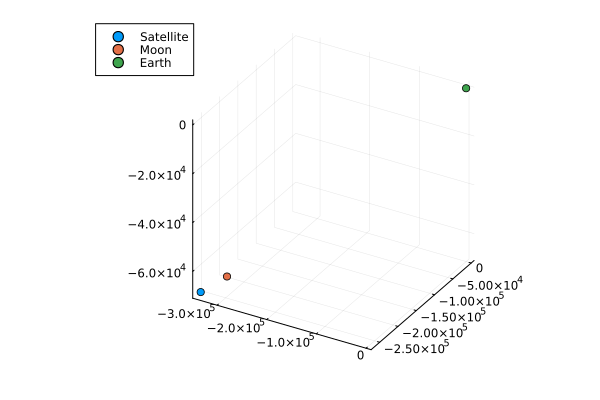

In [55]:
#these dynamics are all relative to the Earth
scatter([sat_pose[1]], [sat_pose[2]], [sat_pose[3]], label="Satellite")
scatter!([moon_pose[1]], [moon_pose[2]], [moon_pose[3]], label= "Moon")
scatter!([0], [0], [0], label = "Earth")

In [57]:
#the x is scaled here as well as the t 

function scaled_ephemeris_dynamics(x,t)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)

    #get to original units (km and s)
    q_original = x[1:3]*l_star 
    v_original = x[4:6]*(l_star/t_star)
    t_original = t*t_star

    x_original = [q_original; v_original]

    #original is in the CR3BP units
    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = ephemeris_model_EarthMoon(x_original, t_original)
    
    #then scale the output
    v_scaled = ẋ_original[1:3]/(l_star/t_star)
    
    a_scaled = ẋ_original[4:6]/(l_star/(t_star)^2)

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

scaled_ephemeris_dynamics (generic function with 1 method)

In [58]:
L_cr = 3.850e5 #in km - distance between centers of m1 and m2
V_cr = 1.025 #in km/s - orbital velocity of m1
T_cr = 2.361e6 #in seconds - orbital period of m1 and m2
time_scale = T_cr/(2*pi)

375764.8206399649

In [59]:
L_nasa = 389703
T_nasa = 382981

382981

In [60]:
#mass paramter for earth moon
μ_earth_moon = 1.215058560962404E-2

0.01215058560962404

In [61]:
#position of Earth in rotating frame
pose_m1 = [-μ_earth_moon, 0, 0]

3-element Vector{Float64}:
 -0.01215058560962404
  0.0
  0.0

In [62]:
pose_m2 = [1-μ_earth_moon, 0, 0]

3-element Vector{Float64}:
 0.987849414390376
 0.0
 0.0

In [63]:
norm(pose_m2 - x0_test[1:3])*L_cr 

50979.23635721503

In [64]:
x0_test = [1.1201297302380415,
 0.0,
 0.0059396759100811495,
 0.0,
 0.17677819141944426,
 0.0]

 x0_test_earthcentered = [x0_test[1:3] - pose_m1; x0_test[4:6]]

 #in cr3bp units 
T_periodic = 3.414975413662902

x0_dim = [x0_test_earthcentered[1:3]*L_cr; x0_test_earthcentered[4:6]*(L_cr/T_cr)]

T_dim = T_periodic*time_scale

1.2832276238049301e6

In [65]:
################################################################################################################
#from https://ssd.jpl.nasa.gov/tools/periodic_orbits.html

#in nasa cr3bp units
#x0_test = [1.1808985497899205E+0, -2.5444988241150091E-26, 1.0295054075242347E-4, 3.3765359485568778E-15, -1.5585631393981156E-1, 5.5263881873244218E-18]
#T_periodic = 3.4155308065628454

#larger orbit
# x0_test = [1.1805068248439281E+0,	-3.3114436259161434E-27,	1.9906874796338979E-2,	3.3672394329658290E-15,	-1.5811356683023692E-1, 2.2436379855191516E-15]
# T_periodic = 3.1503862907153901
# x0_test_earthcentered = [x0_test[1:3] - pose_m1; x0_test[4:6]]


# x0_dim = [x0_test_earthcentered[1:3]*L_nasa; x0_test_earthcentered[4:6]*(L_nasa/T_nasa)]

# T_dim = T_periodic*T_nasa
#################################################################################################################

In [66]:
x_test_ephem = cr3bp_to_ephem(x0_dim, 0)

6-element Vector{Float64}:
   35677.75392672705
 -383227.521788774
 -204700.13822902984
       1.1169697806195908
       0.09462041520675622
       0.017536997176863373

In [67]:
ephemeris_model_EarthMoon(x_test_ephem, 0)

6-element Vector{Float64}:
  1.1169697806195908
  0.09462041520675622
  0.017536997176863373
 -2.713532502393513e-7
  2.9214119061117146e-6
  1.5206806829616711e-6

In [68]:
x_test_ephem_scaled = [x_test_ephem[1:3]/l_star; x_test_ephem[4:6]/(l_star/t_star)]

T_ephem_scaled = T_dim/t_star

3.403027188305123

In [69]:

sol = just_dynamics_integrate_scaled(x_test_ephem_scaled, T_ephem_scaled)

all_states = get_state(sol)

6×45 Matrix{Float64}:
  0.0925031   0.113115    0.131606   …   0.592024   0.496082   0.477873
 -0.993609   -0.99167    -0.9896         1.55421    1.6532     1.67103
 -0.530734   -0.53031    -0.529759       0.807134   0.863123   0.873238
  1.09204     1.08999     1.08788       -0.578229  -0.59141   -0.593403
  0.0925086   0.112787    0.130899       0.624405   0.583718   0.576402
  0.0171456   0.0277084   0.0371551  …   0.35222    0.331007   0.32718

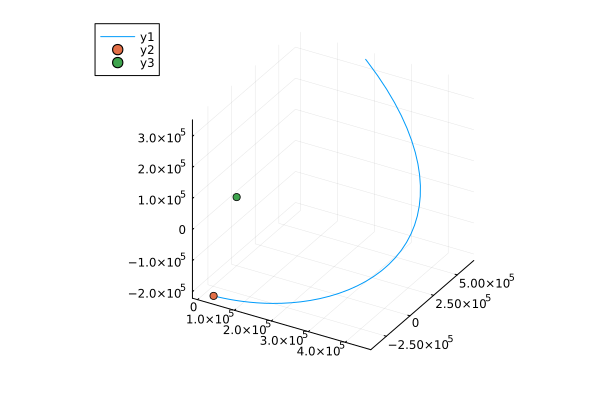

In [70]:
plot(all_states[1,:]*l_star, all_states[2,:]*l_star, all_states[3,:]*l_star) 
scatter!([all_states[1,1]*l_star], [all_states[2,1]*l_star], [all_states[3,1]*l_star])
scatter!([0], [0], [0])

In [ ]:
#problem: gravity of the moon is much lower than the gravity of Earth 

In [ ]:
using DelimitedFiles
xtraj  = readdlm("xtraj.txt", '\t', Float64, '\n')

#in days
time_steps = readdlm("time.txt", '\t', Float64, '\n')
#period 
T_periodic_n = 3.414975413662902

In [ ]:
#units of km and days

In [ ]:
xtraj

In [ ]:
μ_earth_moon*L_cr 

In [ ]:
xtraj

In [ ]:
xtraj_transformed = [xtraj[1:3, :].+ [4677.975459705256, 0, 0]; xtraj[4:6, :]./86400]

In [ ]:
#make sure to divide by 86400 to get into seconds

In [ ]:
time_steps[2]

In [ ]:
time_steps

In [ ]:
#transform each of these points into the Earth Moon ephemeris model to see what it looks like

xtraj_ephemeris = zeros(6,131)

x_centered = xtraj_ephemeris 

for i=1:131

    xtraj_ephemeris[:,i] = cr3bp_to_ephem(xtraj_transformed[:,i], time_steps[i]*86400)
end

In [ ]:
xtraj_ephemeris

In [ ]:
[all_states[1:3, :].*l_star; all_states[4:6,:].*(l_star/t_star)] 

In [ ]:
plot(xtraj_ephemeris[1,:], xtraj_ephemeris[2,:], xtraj_ephemeris[3,:])

plot!(all_states[1,:]*l_star, all_states[2,:]*l_star, all_states[3,:]*l_star) 
scatter!([all_states[1,1]*l_star], [all_states[2,1]*l_star], [all_states[3,1]*l_star])
scatter!([0], [0], [0])

In [ ]:
moon_orbit = zeros(6, 1000000)


for i=1:1000000

    moon_orbit[:,i] = spkezr("moon",et+i,"J2000","NONE","earth")[1]

end

In [ ]:
plot(moon_orbit[1,:], moon_orbit[2,:], moon_orbit[3,:])

scatter!([0], [0], [0])

In [ ]:
#I believe there is something wrong with the epoch...